# Pandemic Data Science | EDA Railway

In [1]:
# Import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import LineString
import json
import contextily as ctx
from tqdm import tqdm
import copy
from geopy.distance import geodesic

## Visualizing the Railway Networks

In [2]:
states_df = gpd.read_file('../geoplots_json/india_state.geojson')
states_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
0,105,IND,India,1,Andaman and Nicobar,None,Andaman & Nicobar Islands|Andaman et Nicobar|I...,Union Territor,Union Territory,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,105,IND,India,2,Andhra Pradesh,None,None,State,State,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13..."
2,105,IND,India,3,Arunachal Pradesh,None,Agence de la Frontire du Nord-Est(French-obsol...,State,State,"POLYGON ((96.15778 29.38310, 96.16380 29.37668..."
3,105,IND,India,4,Assam,None,None,State,State,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25..."
4,105,IND,India,5,Bihar,None,None,State,State,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26..."


### Trains Data

In [37]:
with open('../Datasets/railway/trains.json') as f:
  data = json.load(f)

trains_df = {
    'name':[],
    'from':[],
    'to':[],
    'duration':[],
    'geometry':[]
}

empty_trains = []
for i in range(len(data['features'])):
    props = data['features'][i]['properties']
    cords = (data['features'][i]['geometry']['coordinates'])
    try:
        linestring = LineString(cords)
        trains_df['name'].append(props['name'])
        trains_df['from'].append(props['from_station_code'])
        trains_df['to'].append(props['to_station_code'])
        trains_df['duration'].append(props['duration_h'])
        trains_df['geometry'].append(linestring)
    except:
        empty_trains.append(props['name'])

In [38]:
trains_df = pd.DataFrame(trains_df)
trains_df.head()

,name,from,to,duration,geometry
0,Jammu Tawi Udhampur Special,JAT,UHP,1.0,"LINESTRING (74.880117 32.706975, 74.953339 32...."
1,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.154881 32.92664, 75.14542599999..."
2,JAT UDAHMPUR DMU,JAT,UHP,1.0,"LINESTRING (74.880117 32.706975, 74.953339 32...."
3,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.154881 32.92664, 75.14542599999..."
4,Mumbai BandraT-Bikaner SF Special,BDTS,BKN,21.0,"LINESTRING (72.840535 19.061911, 72.8400780000..."


In [39]:
trains_gdf = gpd.GeoDataFrame(trains_df, crs="EPSG:3857")

In [40]:
print("Total Number of active trains:", trains_df.shape[0])

Total Number of active trains: 5199


Here is a list of trains that aren't running - 

In [41]:
empty_trains

['Moti Koral Miyagam Mix Passenger',
 'Miyagam Moti Koral Mix Passenger',
 'Pulgaon Arvi Passenger',
 'Arvi Pulgaon Passenger',
 'Dildarnagar Tarighat Passenger',
 'Tarighat Dildarnagar Passenger',
 'JAMALPUR MONGHYAR PASS',
 'Tiruturaipdi Tiruvarur Passenger',
 'Tiruvarur Tiruturaipudi Passenger']

### Stations Data

In [42]:
stations_gdf = gpd.read_file('../Datasets/railway/stations.json')
stations_gdf = stations_gdf.fillna(np.nan)
stations_gdf.head()

,state,code,name,zone,address,geometry
0,Rajasthan,BDHL,Badhal,NWR,"Kishangarh Renwal, Rajasthan",POINT (75.45165 27.25206)
1,NaN,XX-BECE,XX-BECE,NaN,NaN,None
2,NaN,XX-BSPY,XX-BSPY,NaN,NaN,None
3,NaN,YY-BPLC,YY-BPLC,NaN,NaN,None
4,Uttar Pradesh,KHH,KICHHA,NER,"Kichha, Uttar Pradesh",POINT (79.51975 28.91343)


Now, we have stations data and the rail network. We just need to merge the two

### Merge Data

In [43]:
from_state_list = []
to_state_list = []
for _, row in tqdm(trains_gdf.iterrows()):
    from_stn_code = row['from']
    to_stn_code = row['to']
    from_state = list(stations_gdf.loc[stations_gdf['code'] == from_stn_code]['state'])[0]
    to_state = list(stations_gdf.loc[stations_gdf['code'] == to_stn_code]['state'])[0]
    from_state_list.append(from_state)
    to_state_list.append(to_state)

5199it [00:21, 244.48it/s]


In [44]:
trains_gdf['to_state'] = to_state_list
trains_gdf['from_state'] = from_state_list
trains_gdf = trains_gdf.dropna().reset_index(drop=True)

In [45]:
trains_gdf.head()

,name,from,to,duration,geometry,to_state,from_state
0,Jammu Tawi Udhampur Special,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir
1,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir
2,JAT UDAHMPUR DMU,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir
3,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir
4,Sirsa - Hisar Passenger Special,SSA,HSR,1.0,"LINESTRING (75.03494 29.53915, 75.17032 29.515...",Haryana,Haryana


In [46]:
# Select those stations that exist in trains_gdf
active_stn_codes = list(set(trains_gdf['from']).union(set(trains_gdf['to'])))
active_stn_codes

['VSG',
 'BNKI',
 'CPK',
 'MTP',
 'KMC',
 'BARI',
 'DEE',
 'RMR',
 'SUNR',
 'KOP',
 'MUT',
 'KPV',
 'INDB',
 'KLK',
 'GDG',
 'MHOW',
 'RDP',
 'INDM',
 'SOE',
 'REWA',
 'MYS',
 'LKKA',
 'BTI',
 'LMP',
 'BKF',
 'DMR',
 'MTC',
 'AGTL',
 'APH',
 'GDV',
 'MHV',
 'JRU',
 'MAQ',
 'CDD',
 'JAT',
 'SHTT',
 'KODR',
 'BDHN',
 'CHV',
 'BIR',
 'BME',
 'TSK',
 'TCN',
 'PRLI',
 'QLM',
 'ABKP',
 'BVC',
 'ATT',
 'SHC',
 'RGV',
 'KTW',
 'BTC',
 'PLK',
 'BDTS',
 'GG',
 'BI',
 'NZB',
 'RHA',
 'BL',
 'SWV',
 'MVJ',
 'SRMT',
 'BMO',
 'DDN',
 'DLJ',
 'KRBA',
 'TN',
 'LMG',
 'JRBM',
 'DVA',
 'MAO',
 'MUGR',
 'DJRZ',
 'MFR',
 'TTP',
 'BHUJ',
 'JMKR',
 'MV',
 'NTW',
 'BGKT',
 'HYB',
 'BIM',
 'PAU',
 'AII',
 'STA',
 'FKG',
 'HPT',
 'LGL',
 'BQA',
 'BNW',
 'BRMP',
 'KNLS',
 'NRW',
 'HSX',
 'CUR',
 'RE',
 'DWR',
 'LD',
 'MLN',
 'RIM',
 'JJP',
 'DLI',
 'TK',
 'MJ',
 'AZ',
 'RTGH',
 'MBA',
 'JSM',
 'CDG',
 'BTD',
 'DAS',
 'LGH',
 'KJV',
 'BGM',
 'BGNA',
 'PRG',
 'RRB',
 'BJE',
 'ABS',
 'JTTN',
 'JBP',
 'PRTN',
 'MKP

In [47]:
active_stn_gdf = copy.deepcopy(stations_gdf)
for idx, row in active_stn_gdf.iterrows():
    if row['code'] not in active_stn_codes:
        active_stn_gdf = active_stn_gdf.drop(index=idx)

active_stn_gdf = active_stn_gdf.reset_index(drop=True)
active_stn_gdf.dropna()
active_stn_gdf.shape
# idx = 0
# for _, row in stations_gdf.iterrows():
#     active_stn_df.loc[idx] = row
#     break

(292, 6)

In [48]:
active_stn_gdf = active_stn_gdf.dropna(subset=['state'])

### Plotting Final Data

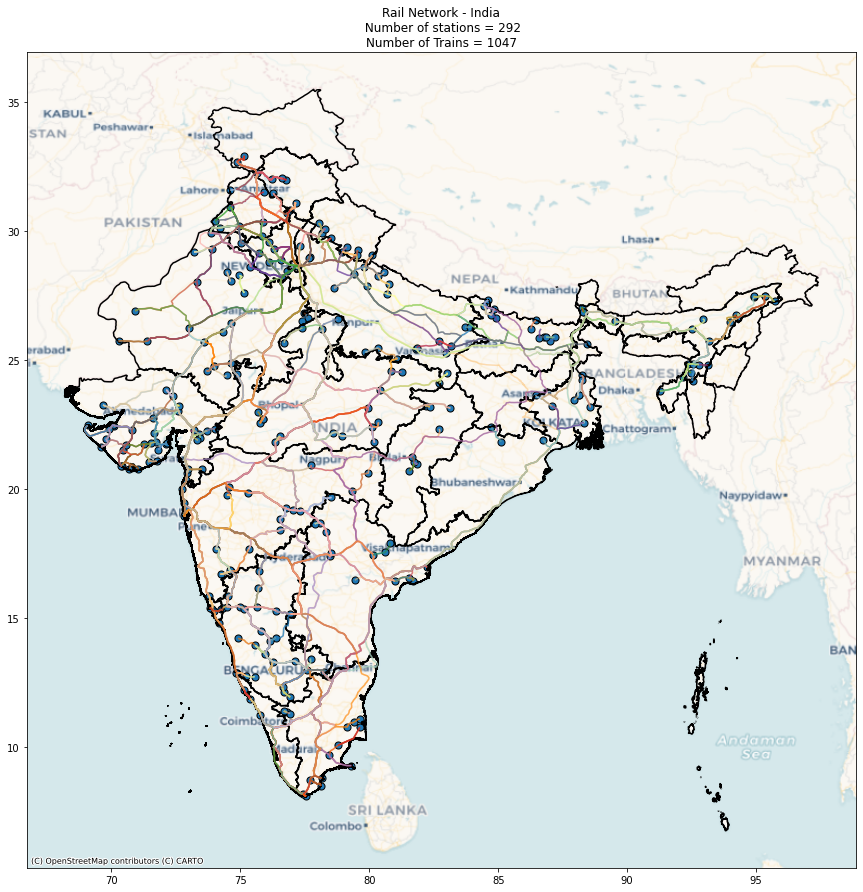

In [49]:
# stations_gdf.loc[stations_gdf['code'] == 'BDHL']
states_plot = states_df['geometry']
base = states_plot.boundary.plot(edgecolor='black', figsize=(15,15))
stns_plot = active_stn_gdf.plot(ax=base, label=True, markersize=50, edgecolor='black')
ax = trains_gdf.plot(ax=stns_plot, alpha=0.5, column='name', cmap='Paired')
ax.set_title("Rail Network - India\n Number of stations = {}\nNumber of Trains = {}".format(active_stn_gdf.shape[0], trains_gdf.shape[0]))
ctx.add_basemap(base, crs=states_plot.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.show()
# for idx, row in trains_df

## Inferences

Not much inferences need to be drawn from this dataset. Mostly because this dataset will be use to show the results. Won't be used much in deriving the vulnerability index

### Number of Stations per state

In [50]:
# Number of stations per state
states = list(set(active_stn_gdf['state']))
# states.remove(None)

for state in states:
    count = len(active_stn_gdf.loc[active_stn_gdf['state'] == state])
    print("Number of stations in {}: {}".format(state, count))
#     stn_count += count

Number of stations in Maharashtra: 24
Number of stations in Punjab: 8
Number of stations in Chhattisgarh: 7
Number of stations in Jammu and Kashmir: 2
Number of stations in Uttarakhand: 10
Number of stations in Andhra Pradesh: 14
Number of stations in Chandigarh: 1
Number of stations in Haryana: 10
Number of stations in Gujarat: 40
Number of stations in Tripura: 2
Number of stations in Assam: 17
Number of stations in Uttar Pradesh: 23
Number of stations in Kerala: 3
Number of stations in Bihar: 13
Number of stations in Rajasthan: 23
Number of stations in Karnataka: 29
Number of stations in Mizoram: 1
Number of stations in Madhya Pradesh: 21
Number of stations in Delhi NCT: 2
Number of stations in Tamil Nadu: 16
Number of stations in Orissa: 2
Number of stations in Himachal Pradesh: 5
Number of stations in Odisha: 1
Number of stations in West Bengal: 13
Number of stations in Goa: 4
Number of stations in Jharkhand: 1


In [51]:
def linestring_to_points(line):
    return list(line.coords)

trains_gdf['points'] = trains_gdf.apply(lambda l: linestring_to_points(l['geometry']),axis=1)

In [52]:
trains_gdf.head(5)

,name,from,to,duration,geometry,to_state,from_state,points
0,Jammu Tawi Udhampur Special,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir,"[(74.880117, 32.706975), (74.953339, 32.762368..."
1,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir,"[(75.154881, 32.92664), (75.14542599999999, 32..."
2,JAT UDAHMPUR DMU,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir,"[(74.880117, 32.706975), (74.953339, 32.762368..."
3,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir,"[(75.154881, 32.92664), (75.14542599999999, 32..."
4,Sirsa - Hisar Passenger Special,SSA,HSR,1.0,"LINESTRING (75.03494 29.53915, 75.17032 29.515...",Haryana,Haryana,"[(75.034944, 29.539153), (75.170322, 29.515832..."


In [53]:
dist_list = []
for _, row in tqdm(trains_gdf.iterrows()):
    dist = 0
    coords = row['points']
#     if len(coords) % 2:
#         print(len(coords))
#         print(row['name'])
# #         break
    for i in range(0, len(coords)-1):
        dist += geodesic(reversed(coords[i]), reversed(coords[i+1])).km
    dist_list.append(dist)

1047it [00:10, 103.70it/s]


In [54]:
trains_gdf['distance'] = dist_list

In [55]:
trains_gdf.describe()

,duration,distance
count,1047.000000,1047.000000
mean,8.462273,384.871043
std,11.632694,593.980515
min,0.000000,13.611944
25%,2.000000,65.309560
50%,4.000000,136.512121
75%,10.000000,427.610854
max,85.000000,4100.401356


Text(0.5, 1.0, 'Histogram Plot - Distance covered by Trains in India')

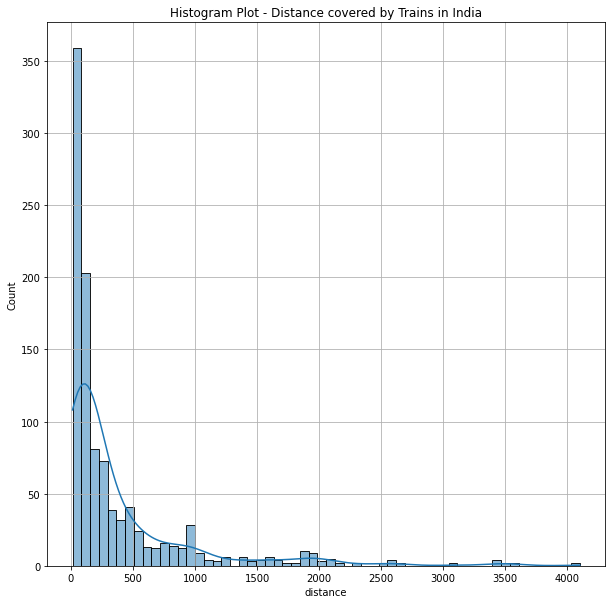

In [56]:
# plt.plot(trains_gdf['id'],trains_gdf['distance'])
fig = plt.figure(figsize=(10,10))
sns.histplot(data=trains_gdf, x='distance', kde=True)
plt.grid()
plt.title("Histogram Plot - Distance covered by Trains in India")

Text(0.5, 1.0, 'Histogram Plot - Duration')

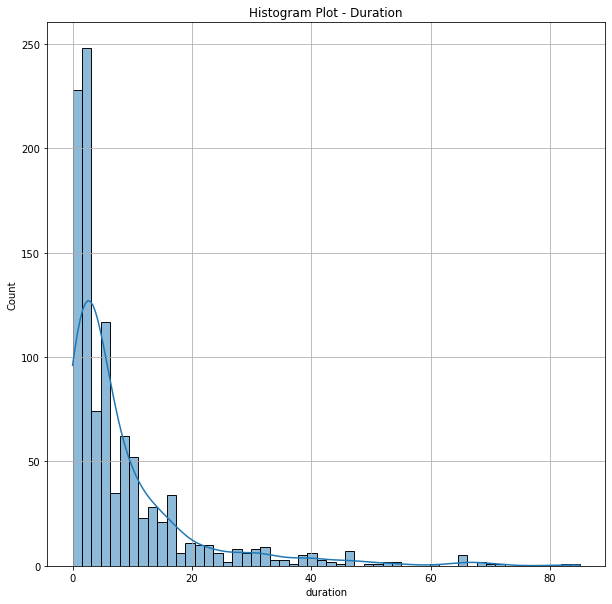

In [61]:
# plt.plot(trains_gdf['id'],trains_gdf['distance'])
fig = plt.figure(figsize=(10,10))
sns.histplot(data=trains_gdf, x='duration', kde=True)
plt.grid()
plt.title("Histogram Plot - Duration")

It is clearly visible that it doesn't follow a normal distribution but rather follows a power law distribution

In [57]:
trains_gdf.head()

,name,from,to,duration,geometry,to_state,from_state,points,distance
0,Jammu Tawi Udhampur Special,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir,"[(74.880117, 32.706975), (74.953339, 32.762368...",45.824615
1,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir,"[(75.154881, 32.92664), (75.14542599999999, 32...",45.824615
2,JAT UDAHMPUR DMU,JAT,UHP,1.0,"LINESTRING (74.88012 32.70697, 74.95334 32.762...",Jammu and Kashmir,Jammu and Kashmir,"[(74.880117, 32.706975), (74.953339, 32.762368...",45.824615
3,UDHAMPUR JAMMUTAWI DMU,UHP,JAT,1.0,"LINESTRING (75.15488 32.92664, 75.14543 32.863...",Jammu and Kashmir,Jammu and Kashmir,"[(75.154881, 32.92664), (75.14542599999999, 32...",45.824615
4,Sirsa - Hisar Passenger Special,SSA,HSR,1.0,"LINESTRING (75.03494 29.53915, 75.17032 29.515...",Haryana,Haryana,"[(75.034944, 29.539153), (75.170322, 29.515832...",81.379422


## Save Created Datasets

In [58]:
active_stn_json = active_stn_gdf.to_json()
with open('../final_datasets/json/active_stn.json', 'w') as f:
    f.write(active_stn_json)

In [59]:
trains_json = trains_gdf.to_json()
with open('../final_datasets/json/trains_final.json', 'w') as f:
    f.write(trains_json)

In [60]:
trains_df = gpd.read_file("../final_datasets/json/trains_final.json")
trains_df

,id,distance,duration,from,from_state,name,points,to,to_state,geometry
0,0,45.824615,1.0,JAT,Jammu and Kashmir,Jammu Tawi Udhampur Special,"[ [ 74.880116999999998, 32.706975 ], [ 74.9533...",UHP,Jammu and Kashmir,"LINESTRING (74.88012 32.70697, 74.95334 32.762..."
1,1,45.824615,1.0,UHP,Jammu and Kashmir,UDHAMPUR JAMMUTAWI DMU,"[ [ 75.154881000000003, 32.926639999999999 ], ...",JAT,Jammu and Kashmir,"LINESTRING (75.15488 32.92664, 75.14543 32.863..."
2,2,45.824615,1.0,JAT,Jammu and Kashmir,JAT UDAHMPUR DMU,"[ [ 74.880116999999998, 32.706975 ], [ 74.9533...",UHP,Jammu and Kashmir,"LINESTRING (74.88012 32.70697, 74.95334 32.762..."
3,3,45.824615,1.0,UHP,Jammu and Kashmir,UDHAMPUR JAMMUTAWI DMU,"[ [ 75.154881000000003, 32.926639999999999 ], ...",JAT,Jammu and Kashmir,"LINESTRING (75.15488 32.92664, 75.14543 32.863..."
4,4,81.379422,1.0,SSA,Haryana,Sirsa - Hisar Passenger Special,"[ [ 75.034943999999996, 29.539152999999999 ], ...",HSR,Haryana,"LINESTRING (75.03494 29.53915, 75.17032 29.515..."
...,...,...,...,...,...,...,...,...,...,...
1042,1042,13.871425,1.0,ONR,Tamil Nadu,Coonoor Udagamandalam Passenger,"[ [ 76.791336999999999, 11.343714 ], [ 76.7860...",UAM,Tamil Nadu,"LINESTRING (76.79134 11.34371, 76.78608 11.355..."
1043,1043,150.208635,4.0,ASK,Karnataka,Arsikere Mysore Passenger,"[ [ 76.252084800000006, 13.314425 ], [ 76.2495...",MYS,Karnataka,"LINESTRING (76.25208 13.31442, 76.24952 13.226..."
1044,1044,49.372686,1.0,PBR,Gujarat,Porbandar Bhanvad Passenger,"[ [ 69.615505999999996, 21.643597999999997 ], ...",BNVD,Gujarat,"LINESTRING (69.61551 21.64360, 69.72608 21.698..."
1045,1045,191.688268,4.0,BL,Gujarat,Valsad Mumbai Passenger,"[ [ 72.933529100000001, 20.608559499999998 ], ...",BCT,Maharashtra,"LINESTRING (72.93353 20.60856, 72.92713 20.544..."
